In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv(r'C:\Users\Saroj\Electricity_demand\Data\corrected_daily_energy_met_MU.csv')

In [3]:
df.head()

,Date,Region,demand_MU
0,1/1/2013,Gujarat,231.1
1,1/1/2013,Maharashtra,353.1
2,1/1/2013,Tamil Nadu,245.3
3,1/1/2013,Uttar Pradesh,219.2
4,1/2/2013,Gujarat,237.5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15820 entries, 0 to 15819
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15820 non-null  object 
 1   Region     15820 non-null  object 
 2   demand_MU  15820 non-null  float64
 3   month_no   15820 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 494.5+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15820 entries, 0 to 15819
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       15820 non-null  datetime64[ns]
 1   Region     15820 non-null  object        
 2   demand_MU  15820 non-null  float64       
 3   month_no   15820 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 494.5+ KB


In [10]:
df.describe()

,Date,demand_MU,month_no
count,15820,15820.000000,15820.000000
mean,2018-10-04 23:18:51.428571392,341.444870,6.480152
min,2013-01-01 00:00:00,144.000000,1.000000
25%,2015-12-22 00:00:00,276.600000,4.000000
50%,2018-09-23 00:00:00,323.300000,6.000000
75%,2021-08-07 00:00:00,395.700000,10.000000
max,2024-04-28 00:00:00,643.800000,12.000000
std,NaN,86.962843,3.457387


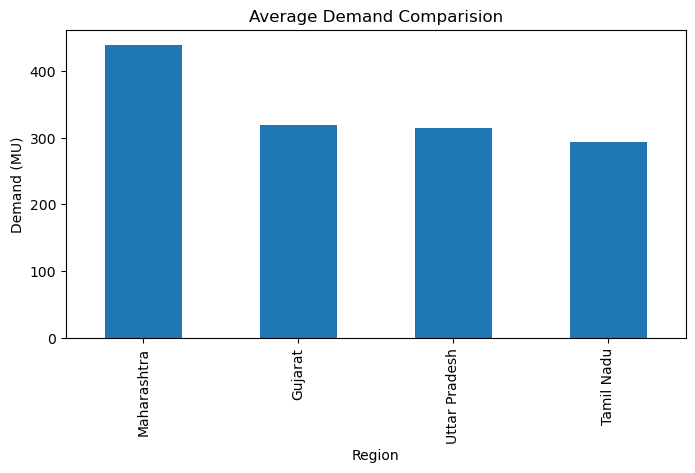

In [11]:
#Region-wise Demand Comparison
region_avg = df.groupby('Region')['demand_MU'].mean().sort_values(ascending=False)
region_avg.plot(kind='bar',figsize=(8,4), title = "Average Demand Comparision")
plt.ylabel("Demand (MU)")
plt.show()

In [12]:
#Create Monthly Dataset
import pandas as pd

# Filter Maharashtra
mh_df = df[df['Region'] == 'Maharashtra'].copy()
# Convert Date → Year-Month
mh_df['Year_Month'] = mh_df['Date'].dt.to_period('M')
# Aggregate monthly demand
monthly_mh = (mh_df.groupby('Year_Month')['demand_MU'].sum().reset_index())
# Convert back to timestamp (for plotting & models)
monthly_mh['Year_Month'] = monthly_mh['Year_Month'].dt.to_timestamp()
# Sort by month
monthly_mh = monthly_mh.sort_values('Year_Month')

monthly_mh.head()

,Year_Month,demand_MU
0,2013-01-01,2522.6
1,2013-03-01,337.8
2,2013-04-01,10932.8
3,2013-05-01,11045.8
4,2013-06-01,8709.0


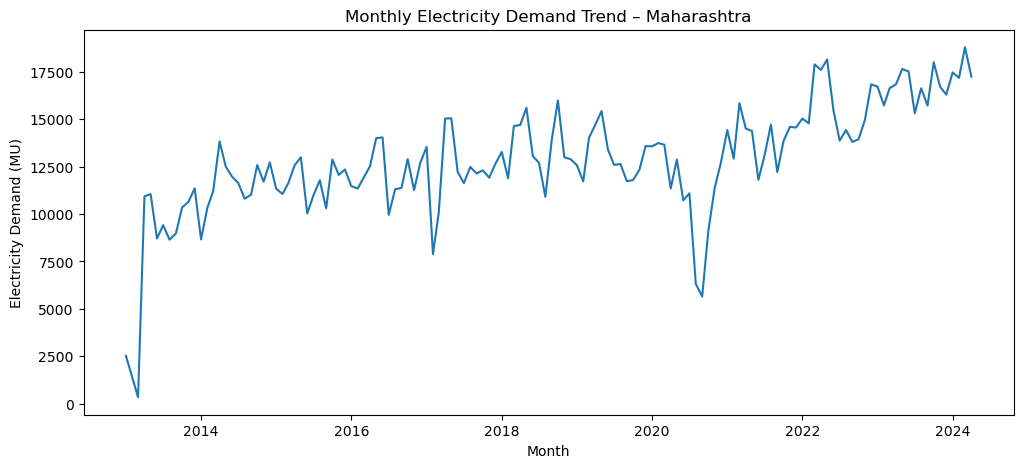

In [13]:
plt.figure(figsize=(12,5))
plt.plot(monthly_mh['Year_Month'], monthly_mh['demand_MU'])
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MU)')
plt.title('Monthly Electricity Demand Trend – Maharashtra')
plt.show()

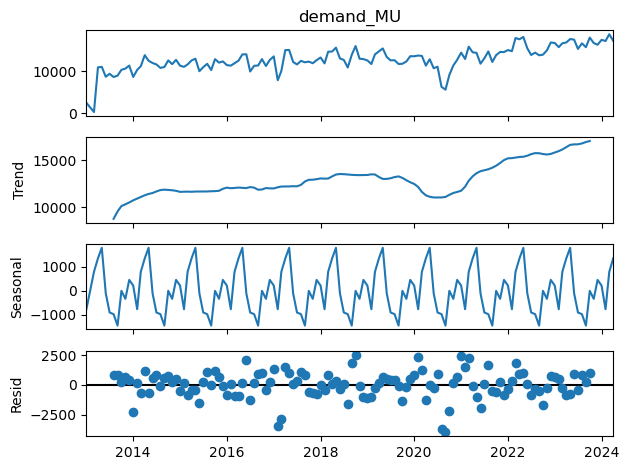

In [14]:
decomposition = seasonal_decompose(monthly_mh.set_index('Year_Month')['demand_MU'], model='additive', period=12)

decomposition.plot()
plt.show()


In [15]:
mh_df[
    (mh_df['Date'].dt.year == 2013) & 
    (mh_df['Date'].dt.month == 2)
]


,Date,Region,demand_MU,month_no,Year_Month


In [16]:
monthly_mh_clean = monthly_mh[monthly_mh['Year_Month'] >= '2013-04-01']


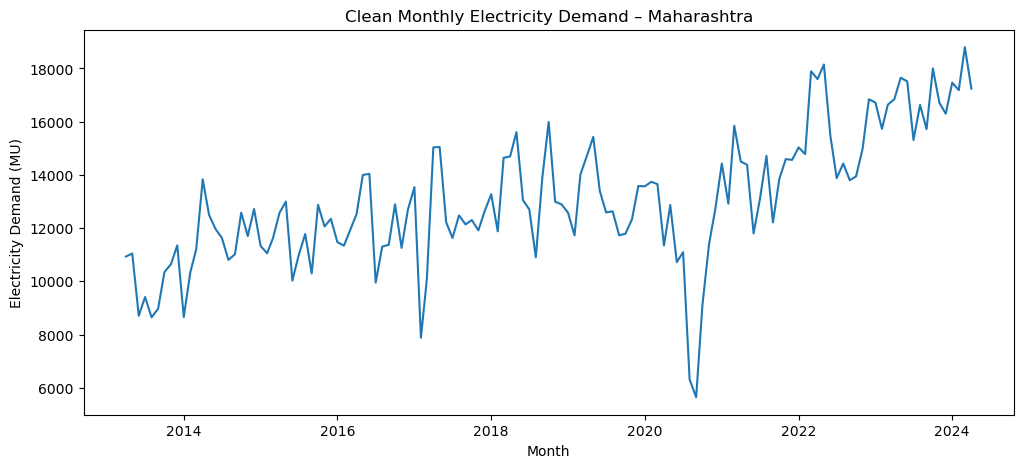

In [17]:
plt.figure(figsize=(12,5))
plt.plot(monthly_mh_clean['Year_Month'], monthly_mh_clean['demand_MU'])
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MU)')
plt.title('Clean Monthly Electricity Demand – Maharashtra')
plt.show()


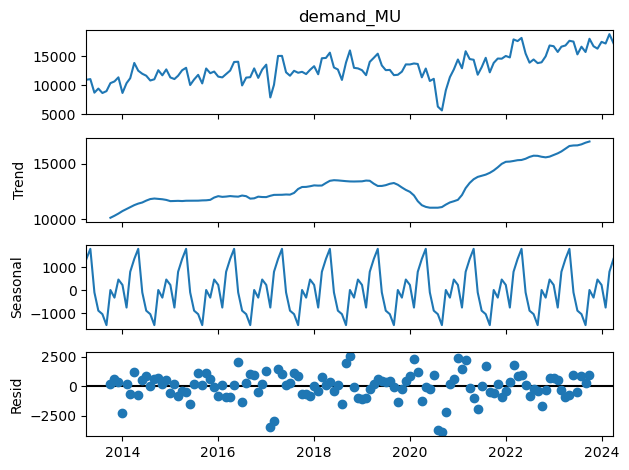

In [18]:
decomposition = seasonal_decompose(
    monthly_mh_clean.set_index('Year_Month')['demand_MU'],
    model='additive',
    period=12
)
decomposition.plot()
plt.show()


In [19]:
monthly_mh_clean = monthly_mh_clean.reset_index(drop=True)
monthly_mh_clean['t'] = np.arange(len(monthly_mh_clean))


In [20]:
X = monthly_mh_clean[['t']]
y = monthly_mh_clean['demand_MU']

model = LinearRegression()
model.fit(X, y)

monthly_mh_clean['forecast'] = model.predict(X)


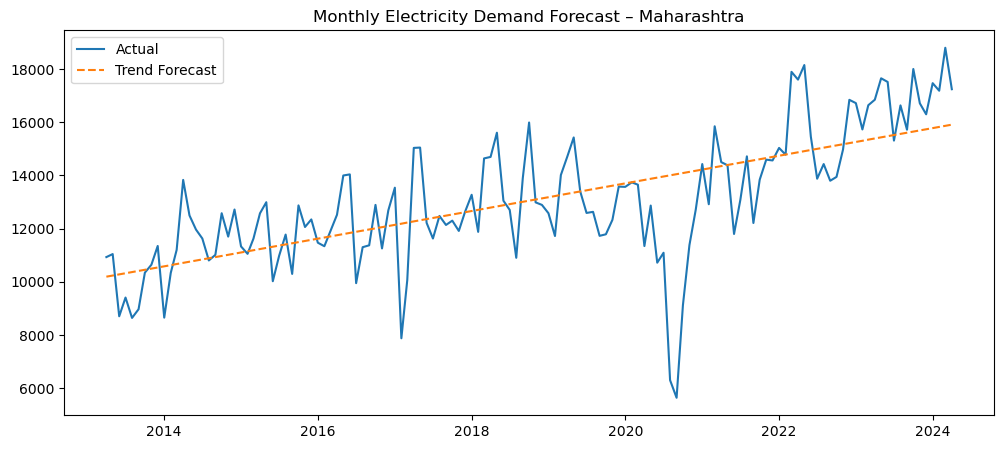

In [21]:
plt.figure(figsize=(12,5))
plt.plot(monthly_mh_clean['Year_Month'], y, label='Actual')
plt.plot(monthly_mh_clean['Year_Month'], monthly_mh_clean['forecast'],
         linestyle='--', label='Trend Forecast')
plt.legend()
plt.title('Monthly Electricity Demand Forecast – Maharashtra')
plt.show()


In [22]:
# Forecast next 12 months
future_months = 12
last_t = monthly_mh_clean['t'].iloc[-1]

future_t = np.arange(last_t + 1, last_t + future_months + 1)
future_X = pd.DataFrame({'t': future_t})

future_forecast = model.predict(future_X)

# Create future dates
last_date = monthly_mh_clean['Year_Month'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                             periods=future_months, freq='MS')

future_df = pd.DataFrame({
    'Year_Month': future_dates,
    'forecast_demand_MU': future_forecast
})


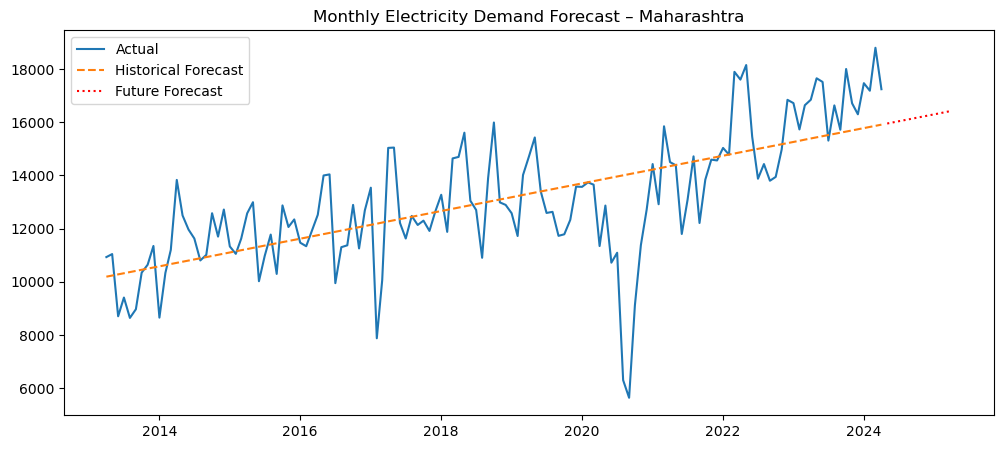

In [23]:
plt.figure(figsize=(12,5))
plt.plot(monthly_mh_clean['Year_Month'], y, label='Actual')
plt.plot(monthly_mh_clean['Year_Month'], monthly_mh_clean['forecast'],
         linestyle='--', label='Historical Forecast')
plt.plot(future_df['Year_Month'], future_df['forecast_demand_MU'],
         linestyle=':', color='red', label='Future Forecast')
plt.legend()
plt.title('Monthly Electricity Demand Forecast – Maharashtra')
plt.show()
